In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from matplotlib.colors import LogNorm
import tqdm
import pickle 



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS122.root",
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS159.root",
    "./ntupleStubsBmtfGmt_LS170.root",
    "./ntupleStubsBmtfGmt_LS214.root",
    "./ntupleStubsBmtfGmt_LS237.root",
    "./ntupleStubsBmtfGmt_LS251.root",
    "./ntupleStubsBmtfGmt_LS258.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS277.root",
    "./ntupleStubsBmtfGmt_LS290.root",
    "./ntupleStubsBmtfGmt_LS299.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 
    'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 
    'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)



In [3]:
bx = bmtf_gmt.bx
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel
stubsPhiB = bmtf_gmt.stubHwPhiB
stubsHwQual = bmtf_gmt.stubHwQual
stubsHwEta = bmtf_gmt.stubHwEta
stubsHwQEta = bmtf_gmt.stubHwQEta
stubsTag = bmtf_gmt.stubTag

In [4]:
#Controlla che la stub successiva si trovi nella stazione dopo
def CheckStation(Station, StationP1, Direction):

   Diff = StationP1 - Station
   Index = ak.where(Diff == Direction)[0]

   return Index

#Controlla che la Wheel successiva sia +- 1 della wheel corrente, tranne per le wheel estremali
def CheckWheel(Wheel, WheelP1):
   
   IndexList = []

   if (Wheel == -2):
      Index = list(ak.where((WheelP1 == -1) | (WheelP1 == -2))[0])
      IndexList.extend(Index)

   elif (Wheel == 2):
      Index = list(ak.where((WheelP1 == 1) | (WheelP1 == 2))[0])
      IndexList.extend(Index)

   else:
      Diff = Wheel - WheelP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)



#Controlla che il settore successivo sia adiacente al settore corrente. Applica operazione ciclica per settori 11 e 0
def CheckSector(Sector, SectorP1):
   
   IndexList = []

   if (Sector == 11):
      Index = list(ak.where((SectorP1 == 10) | (SectorP1 == 11) | (SectorP1 == 0))[0])
      IndexList.extend(Index)

   elif (Sector == 0):
      Index = list(ak.where((SectorP1 == 11) | (SectorP1 == 0)| (SectorP1 == 1))[0])
      IndexList.extend(Index)

   else:
      Diff = Sector - SectorP1
      Index = list(ak.where((Diff == -1) | (Diff == 0) | (Diff == 1))[0])
      IndexList.extend(Index)

   return ak.Array(IndexList)


def FindSeq(arr):
    
    arr = np.sort(arr)
    sequences = []
    current_sequence = [arr[0]]

    for i in range(1, len(arr)):
        
        if arr[i] == arr[i - 1] + 1:
            current_sequence.append(arr[i])
        else:
            
            if len(current_sequence) > 1:
                sequences.append(current_sequence)
            
            current_sequence = [arr[i]]


    if len(current_sequence) > 1:
        sequences.append(current_sequence)

    return sequences

def FindSequenceWithIndex(arr):
    # Ottieni l'array ordinato e gli indici originali degli elementi
    sorted_indices = np.argsort(arr)
    sorted_arr = arr[sorted_indices]
    
    sequences = []
    current_sequence = [sorted_arr[0]]
    current_indices = [sorted_indices[0]]

    for i in range(1, len(sorted_arr)):
        # Controlla se l'elemento corrente è consecutivo rispetto al precedente
        if sorted_arr[i] == sorted_arr[i - 1] + 1:
            current_sequence.append(sorted_arr[i])
            current_indices.append(sorted_indices[i])
        else:
            # Salva la sequenza trovata (valori e indici) se ha più di un elemento
            if len(current_sequence) > 1:
                sequences.append((current_sequence, current_indices))
            # Inizia una nuova sequenza con l'elemento corrente
            current_sequence = [sorted_arr[i]]
            current_indices = [sorted_indices[i]]

    # Aggiungi l'ultima sequenza se è valida
    if len(current_sequence) > 1:
        sequences.append((current_sequence, current_indices))

    return sequences

In [5]:
Features = [nStubs, bx, stubsStation, stubsSector, stubsWheel, stubsPhiB, stubsHwQual, stubsHwEta, stubsHwQEta, stubsTag]

In [6]:
def SearchHSCP_StationLevel(Features, Number):

   Muons = []

   #Feature: 0 == Stubs, 1 == bx, 2 == Station, 3 == Sector, 4 == Wheel, 5 == PhiB, 6 == Quality

   for i in tqdm.tqdm(range(Number - 1)):

      if Features[1][i+1] > Features[1][i] + 5:
         continue

      else:
         
         #Definisco dizionari dove salvo le features di ogni muone e successivo corretti
         Dic = {}
         DicP1 = {}

         #Inizializzo dizionari
         for feature in ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']:
            Dic[feature] = []
            DicP1[feature] = []

         
         #Primo caso: Se il muone si sta muovendo dalla stazione i alla stazione i+1 "in avanti" 
         if((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] + 1 and Features[2][i] != 4):

            #Controllo che per l'iesimo e i+1esimo siano corretti sector e wheel
            IndexSector = CheckSector(Features[3][i], Features[3][i+1])
            IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

            #Se sono corretti salvo nel dizionario e metto il dizionario nella lista 
            if(len(IndexSector) != 0 and len(IndexWheel) != 0):
               Match_nStubs = [1, 1]
               Dir = True

               keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
               for idx, key in enumerate(keys, start=2):
                  Dic[key].extend(Features[idx][i])
                  DicP1[key].extend(Features[idx][i+1])

               Dictionary = {
                  'i': i,
                  'bx': [Features[1][i], Features[1][i+1]],
                  'Matched_nStubs': Match_nStubs,
                  'Dir': Dir,
                  'property': Dic,
                  'propertyP1': DicP1
                  }

               Muons.append(Dictionary)

            else:
               continue

         #Secondo caso: il muone si sta muonendo "all'indietro" e nell'iesimo e i+1esimo bx sono presenti solo 1 muone 
         elif((Features[0][i] == 1 and Features[0][i+1] == 1) and Features[2][i+1] == Features[2][i] - 1 and Features[2][i] != 1):

            #Controllo sector e wheel e salvo 
            IndexSector = CheckSector(Features[3][i], Features[3][i+1])
            IndexWheel = CheckWheel(Features[4][i], Features[4][i+1])

            if(len(IndexSector) != 0 and len(IndexWheel) != 0):
               Match_nStubs = [1, 1]
               Dir = False

               keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
               for idx, key in enumerate(keys, start=2):
                  Dic[key].extend(Features[idx][i])
                  DicP1[key].extend(Features[idx][i+1])


               Dictionary = {
                  'i': i,
                  'bx': [Features[1][i], Features[1][i+1]],
                  'Matched_nStubs': Match_nStubs,
                  'Dir': Dir,
                  'property': Dic,
                  'propertyP1': DicP1
                  }

               Muons.append(Dictionary)

            else:
               continue

         #Terzo caso: nell'iesimo bx è presente più di una stubs e in quello successivo solo 1
         elif (Features[0][i] > 1 and Features[0][i+1] == 1):

            #Controllo se c'è una sequenza nell'iesimo bx
            Sequence = FindSequenceWithIndex(Features[2][i])

            if len(Sequence) == 0:
               continue

            #Se c'è la sequenza:
            else:

               #Loop su tutte le possibili sottosequenze 
               for j in range(len(Sequence)):

                  #Controllo che le sottosequenze siano coerenti, ovvero che Sector e Wheel siano adiacenti
                  InternalIndexSector = CheckSector(Features[3][i][Sequence[j][1][0]], np.array([Features[3][i][Sequence[j][1][1:]]]))
                  InternalIndexWheel = CheckWheel(Features[4][i][Sequence[j][1][0]], np.array([Features[4][i][Sequence[j][1][1:]]]))

                  #Se lo sono
                  if(len(InternalIndexSector) != 0 and len(InternalIndexWheel) != 0):

                     Max, Argmax = np.max(Sequence[j][0]), np.argmax(Sequence[j][0])
                     Min, Argmin = np.min(Sequence[j][0]), np.argmin(Sequence[j][0])

                     #----------------------------------CHECK FORWARD---------------------------------
                     #Controllo se il muone si muone in avanti e in tal caso controllo se wheel e sector dell'iesimo e i+1esimo bx siano coerenti
                     if Features[2][i+1] == Max + 1:
                        IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1])
                        IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1])

                        #In tal caso salvo il dizionario
                        if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                           Match_nStubs = [len(Sequence[j][0]), 1]
                           Dir = True

                           keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                           for idx, key in enumerate(keys, start=2):
                              Dic[key].extend(Features[idx][i][[k for k in Sequence[j][1]]])
                              DicP1[key].extend(Features[idx][i+1])

                           Dictionary = {
                              'i': i,
                              'bx': [Features[1][i], Features[1][i+1]],
                              'Matched_nStubs': Match_nStubs,
                              'Dir': Dir,
                              'property': Dic,
                              'propertyP1': DicP1
                              }

                           Muons.append(Dictionary)

                        else:
                           continue


                     #----------------------------------CHECK BACKWARD---------------------------------
                     #Controllo se sis ta muovendo all'indietro, faccio le stesse operazioni di prima 
                     elif Features[2][i+1] == Min - 1:
                        IndexSector = CheckSector(Features[3][i][Argmin], Features[3][i+1])
                        IndexWheel = CheckWheel(Features[4][i][Argmin], Features[4][i+1])

                        if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                           Match_nStubs = [len(Sequence[j][0]), 1]
                           Dir = False

                           keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                           for idx, key in enumerate(keys, start=2):
                              Dic[key].extend(Features[idx][i][[k for k in Sequence[j][1]]])
                              DicP1[key].extend(Features[idx][i+1])

                           Dictionary = {
                              'i': i,
                              'bx': [Features[1][i], Features[1][i+1]],
                              'Matched_nStubs': Match_nStubs,
                              'Dir': Dir,
                              'property': Dic,
                              'propertyP1': DicP1
                           }

                           Muons.append(Dictionary)

                        else:
                           continue

                     else:
                        continue

                  else:
                     continue

               
         #Quarto caso, se iesimo bx è solo 1 muone e i+1esimo più di uno. Il procedimento è lo stesso del terzo caso
         elif (Features[0][i] == 1 and Features[0][i+1] > 1):

            SequenceP1 = FindSequenceWithIndex(Features[2][i+1])

            if len(SequenceP1) == 0:
               continue

            else:

               for j in range(len(SequenceP1)):

                  InternalIndexSector = CheckSector(Features[3][i+1][SequenceP1[j][1][0]], np.array([Features[3][i+1][SequenceP1[j][1][1:]]]))
                  InternalIndexWheel = CheckWheel(Features[4][i+1][SequenceP1[j][1][0]], np.array([Features[4][i+1][SequenceP1[j][1][1:]]]))

                  if(len(InternalIndexSector) != 0 and len(InternalIndexWheel) != 0):

                     Min, Argmin = np.min(SequenceP1[j][0]), np.argmin(SequenceP1[j][0])
                     Max, Argmax = np.max(SequenceP1[j][0]), np.argmax(SequenceP1[j][0])

                     #----------------------------------CHECK FORWARD---------------------------------
                     if Features[2][i] + 1 == Min:
                        IndexSector = CheckSector(Features[3][i+1][Argmin], Features[3][i])
                        IndexWheel = CheckWheel(Features[4][i+1][Argmin], Features[4][i])

                        if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                           Match_nStubs = [1, len(SequenceP1[j][0])]
                           Dir = True

                           keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                           for idx, key in enumerate(keys, start=2):
                              Dic[key].extend(Features[idx][i])
                              DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[j][1]]])

                           Dictionary = {
                              'i': i,
                              'bx': [Features[1][i], Features[1][i+1]],
                              'Matched_nStubs': Match_nStubs,
                              'Dir': Dir,
                              'property': Dic,
                              'propertyP1': DicP1
                           }

                           Muons.append(Dictionary)

                        else:
                           continue

                     #----------------------------------CHECK BACKWARD---------------------------------
                     elif Features[2][i] - 1 == Max:
                        IndexSector = CheckSector(Features[3][i+1][Argmax], Features[3][i])
                        IndexWheel = CheckWheel(Features[4][i+1][Argmax], Features[4][i])

                        if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                           Match_nStubs = [1, len(SequenceP1[j][0])]
                           Dir = False

                           keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                           for idx, key in enumerate(keys, start=2):
                              Dic[key].extend(Features[idx][i])
                              DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[j][1]]])

                           Dictionary = {
                              'i': i,
                              'bx': [Features[1][i], Features[1][i+1]],
                              'Matched_nStubs': Match_nStubs,
                              'Dir': Dir,
                              'property': Dic,
                              'propertyP1': DicP1
                           }

                           Muons.append(Dictionary)

                        else:
                           continue

                     else:
                        continue
                  
                  else:
                     continue


         #Quinto caso: se nell'iesimo e i+1esimo bx sono presenti più di 1 muone
         else:
            #Controllo la sequenza sia dell'iesimo che i+1esimo
            Sequence = FindSequenceWithIndex(Features[2][i])
            SequenceP1 = FindSequenceWithIndex(Features[2][i+1])

            if (len(SequenceP1) == 0): 
               continue
            elif (len(Sequence) == 0):
               continue

            else:

               #Loop su tutte le sottosequenze dell'iesimo bx con controllo se nelle sottosequenze wheel e sector sono compatibili
               for j in range(len(Sequence)):

                  InternalIndexSector = CheckSector(Features[3][i][Sequence[j][1][0]], np.array([Features[3][i][Sequence[j][1][1:]]]))
                  InternalIndexWheel = CheckWheel(Features[4][i][Sequence[j][1][0]], np.array([Features[4][i][Sequence[j][1][1:]]]))

                  if(len(InternalIndexSector) != 0 and len(InternalIndexWheel) != 0):

                     #Loop su tutte le sottosequenze dell'i+1esimo bx, controllo sector e wheel
                     for y in range(len(SequenceP1)):

                        InternalIndexSector = CheckSector(Features[3][i+1][SequenceP1[y][1][0]], np.array([Features[3][i+1][SequenceP1[y][1][1:]]]))
                        InternalIndexWheel = CheckWheel(Features[4][i+1][SequenceP1[y][1][0]], np.array([Features[4][i+1][SequenceP1[y][1][1:]]]))

                        if(len(InternalIndexSector) != 0 and len(InternalIndexWheel) != 0):

                           Max, Argmax = np.max(Sequence[j][0]), np.argmax(Sequence[j][0])
                           Min, Argmin = np.min(Sequence[j][0]), np.argmax(Sequence[j][0])
                           MaxP1 = np.max(SequenceP1[y][0])
                           MinP1 = np.min(SequenceP1[y][0])

                           #Controllo se la particella si muove avanti
                           if Max + 1 == MinP1:

                              IndexSector = CheckSector(Features[3][i][Argmax], Features[3][i+1][[k for k in SequenceP1[y][1]]])
                              IndexWheel = CheckWheel(Features[4][i][Argmax], Features[4][i+1][[k for k in SequenceP1[y][1]]])

                              if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                                 Match_nStubs = [len(Sequence[j][0]), len(SequenceP1[y][0])]
                                 Dir = True

                                 keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                                 for idx, key in enumerate(keys, start=2):
                                    Dic[key].extend(Features[idx][i][[k for k in Sequence[j][1]]])
                                    DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[y][1]]])

                                 Dictionary = {
                                    'i': i,
                                    'bx': [Features[1][i], Features[1][i+1]],
                                    'Matched_nStubs': Match_nStubs,
                                    'Dir': Dir,
                                    'property': Dic,
                                    'propertyP1': DicP1
                                 }
                                 
                                 Muons.append(Dictionary)

                              else:
                                 continue
                           
                           #Controllo se la particella si muove indietro
                           elif Min - 1 == MaxP1:
                              IndexSector = CheckSector(Features[3][i][Argmin], Features[3][i+1][[k for k in SequenceP1[y][1]]])
                              IndexWheel = CheckWheel(Features[4][i][Argmin], Features[4][i+1][[k for k in SequenceP1[y][1]]])

                              if(len(IndexSector) != 0 and len(IndexWheel) != 0):
                                 Match_nStubs = [len(Sequence[j][0]), len(SequenceP1[y][0])]
                                 Dir = False

                                 keys = ['Station', 'Sector', 'Wheel', 'PhiB', 'Quality', 'HwEta', 'HwQEta', 'Tag']
                                 for idx, key in enumerate(keys, start=2):
                                    Dic[key].extend(Features[idx][i][[k for k in Sequence[j][1]]])
                                    DicP1[key].extend(Features[idx][i+1][[k for k in SequenceP1[y][1]]])

                                 Dictionary = {
                                    'i': i,
                                    'bx': [Features[1][i], Features[1][i+1]],
                                    'Matched_nStubs': Match_nStubs,
                                    'Dir': Dir,
                                    'property': Dic,
                                    'propertyP1': DicP1
                                 }

                                 Muons.append(Dictionary)

                              else:
                                 continue

                           else:
                              continue
                        
                        else:
                           continue


                  else:
                     continue

   return ak.Array(Muons)

In [7]:
#Muons = SearchHSCP_StationLevel(Features, len(Features[0]))

In [8]:
# with open('MuonsMoreStatistic.pkl', 'wb') as f:
#    pickle.dump(Muons, f)


#Muons4.pkl è il file con tutti gli eventi (anche più di 1BX)
with open('MuonsMoreStatistic.pkl', 'rb') as f:
   Muons = pickle.load(f)

with open('Muons4.pkl', 'rb') as f:
   Muons4 = pickle.load(f)

In [29]:
def Check(Muons, Features):

   #Feature: 0 == nStubs, 1 == bx, 2 == Station, 3 == Sector, 4 == Wheel, 5 == PhiB, 6 == Quality

   Mask = []

   for i, idx in tqdm.tqdm(enumerate(Muons['i'])):

      if Features[0][idx] == Muons[i]['Matched_nStubs'][0] and Features[0][idx+1] == Muons[i]['Matched_nStubs'][1]:
         Mask.append(i)
         
      
   return Muons[Mask]

In [30]:
AdjMuons = Check(Muons, Features)

791188it [01:02, 12614.86it/s]


In [31]:
AdjMuons

<Array [{i: 17, bx: [...], ...}, ..., {...}] type='721816 * {i: int64, bx: ...'>

In [ ]:
# def AdjacentBX(Muons):

#    Mask = []
#    ConjMask = []
   
#    for i in tqdm.tqdm(range(len(Muons))):
#       if(Muons[i].bx[0] + 1 == Muons[i].bx[1]):
#          Mask.append(i)

#       else:
#          ConjMask.append(i)

#    return Muons[Mask]

In [ ]:
#AdjMuonsTEST = AdjacentBX(Check(Muons4, Features))

490767it [00:33, 14656.78it/s]
100%|██████████| 225123/225123 [00:15<00:00, 14800.23it/s]


In [11]:
def PhiCosmicMuons(Stubs, Sector):

   Mask = []

   for i in tqdm.tqdm(range(len(Stubs))):

      if (Stubs[i]['property'].Sector[0] in Sector):
         Mask.append(i)

   return Stubs[Mask]

In [12]:
#NegAllMuonsTrue = PhiCosmicMuons(AdjMuons[AdjMuons.Dir == True], [6, 7, 8, 9, 10, 11])
NegAllMuonsTrueTEST = PhiCosmicMuons(Muons4[Muons4.Dir == True], [6, 7, 8, 9, 10, 11])

100%|██████████| 252806/252806 [00:11<00:00, 22499.63it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


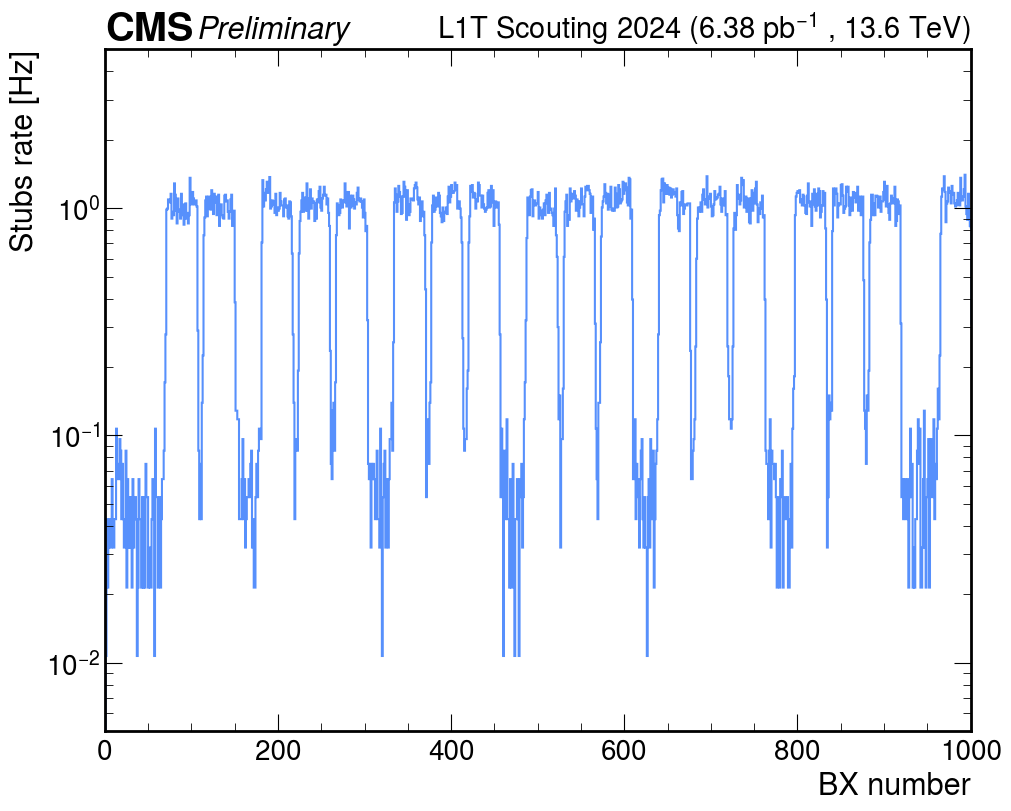

In [38]:
bx_range = np.arange(ONE_ORBIT_IN_BX + 2)

BX_HistPosCosmicMuons = hist.Hist(hist.axis.Variable(bx_range))
BX_HIstNegCosmicJ = hist.Hist(hist.axis.Variable(bx_range))
BX_HistAllMuons = hist.Hist(hist.axis.Variable(bx_range))
BX_HistAllMuonsTrue = hist.Hist(hist.axis.Variable(bx_range))



BX_HistAllMuonsTrue.fill(ak.ravel(NegAllMuonsTrueTEST.bx))


fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


hep.histplot(ConvertToHz(BX_HistAllMuonsTrue)/4)


ax.set_xlabel('BX number')
ax.set_ylabel('Stubs rate [Hz]')
ax.set_xlim(0, ONE_ORBIT_IN_BX)
ax.set_ylim(0.005, 5)
ax.set_xlim(0, 1000)
ax.legend()

ax.set_yscale('log')

plt.savefig("../Immagini/PhiCosmicMuons.pdf")

# Caratterizzazione Stubs

In [32]:
Sum = []
AdjMuonsTrue = AdjMuons

for i in tqdm.tqdm(range(len(AdjMuonsTrue))):
   Sum.append(np.sum(AdjMuonsTrue[i]['Matched_nStubs']))


Hist_nStubsMatch = hist.Hist(hist.axis.Variable(np.arange(2, 6, 1)))
Hist_nStubsMatch.fill(ak.Array(Sum))

100%|██████████| 721816/721816 [00:59<00:00, 12212.07it/s]


Hist(Variable([2, 3, 4, 5], label='Axis 0'), storage=Double()) # Sum: 721816.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


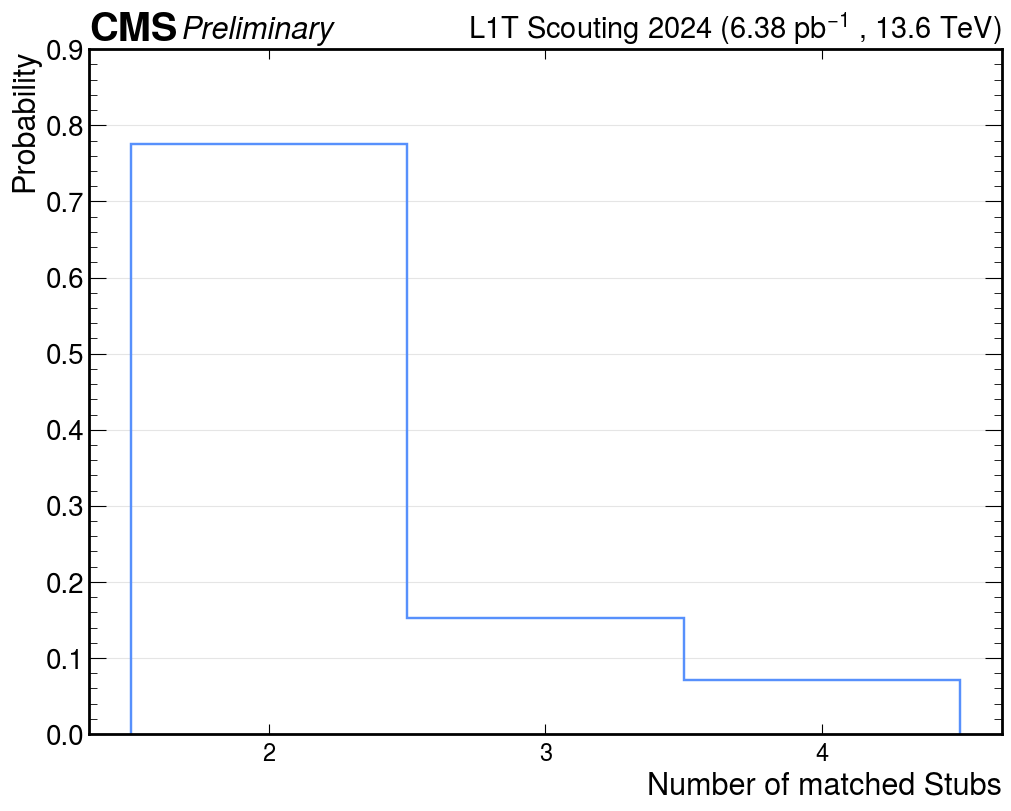

In [33]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_grid(ax, axis="y")

MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(Hist_nStubsMatch, lw = 1.75, density = True)


ax.set_xticks(np.arange(2, 5)+0.5)
ax.set_xticklabels(np.arange(2, 5))

ax.tick_params(axis='x', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='x', which='major', length=7, labelsize = FONTSIZE - 5)
ax.set_ylim(0, 0.9)

ax.set_xlabel('Number of matched Stubs')
ax.set_ylabel('Probability')
#ax.set_yscale('log')

ax.legend()

plt.savefig("../Immagini/MatchedStubs.pdf")

In [34]:
value_to_index = {
    (1, 2): 0,
    (2, 1): 1,
    (1, 3): 2,
    (2, 2): 3,
    (3, 1): 4,
}

Matched = [[] for _ in range(5)]

for i in tqdm.tqdm(range(len(AdjMuons))):
    key = tuple(AdjMuons[i]['Matched_nStubs'])
    index = value_to_index.get(key)
    if index is not None:
        Matched[index].append(AdjMuons[i])
       
Matched = ak.Array(Matched)

100%|██████████| 721816/721816 [00:24<00:00, 29744.04it/s]


/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_22454/1084220580.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2e5)


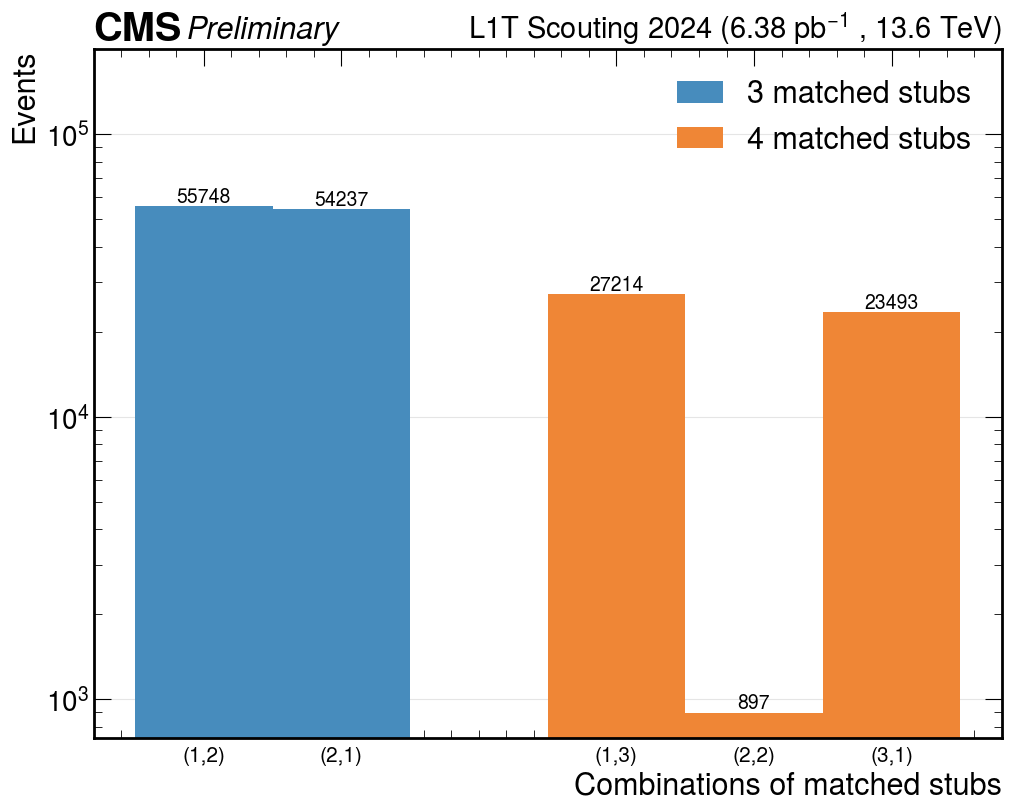

In [39]:
# Dati per le combinazioni
labels_3 = ['(1,2)', '(2,1)']  # Combinazioni per numero di stubs = 3
frequencies_3 = [len(Matched[0]), len(Matched[1])]  # Percentuali per ciascuna combinazione

labels_4 = ['(1,3)', '(2,2)', '(3,1)']  # Combinazioni per numero di stubs = 4
frequencies_4 = [len(Matched[2]), len(Matched[3]), len(Matched[4])]  # Percentuali per ciascuna combinazione

# Impostazioni generali
bar_width = 1
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_grid(ax, axis="y")

MOREdraw_cms_label(ax, fontsize= FONTSIZE)

# Posizioni delle barre
x_3 = np.arange(len(labels_3))  # Posizioni per "3 matched stubs"
x_4 = np.arange(len(labels_4)) + len(x_3) + 1  # Posizioni per "4 matched stubs"

# Barre per le combinazioni di 3 e 4
ax.bar(x_3, frequencies_3, bar_width, color='#478CBD', label='3 matched stubs')
ax.bar(x_4, frequencies_4, bar_width, color='#EF8636', label='4 matched stubs')

# Annotazioni percentuali sopra le barre
for x, freq in zip(x_3, frequencies_3):
    ax.text(x, freq + 1, f'{freq}', ha='center', va='bottom', fontsize=14)
for x, freq in zip(x_4, frequencies_4):
    ax.text(x, freq + 1, f'{freq}', ha='center', va='bottom', fontsize=14)

# Etichette per le barre
all_labels = labels_3 + labels_4
x_positions = list(x_3) + list(x_4)
ax.set_xticks(x_positions)
ax.set_xticklabels(all_labels, fontsize=15)


# Etichette e stile
ax.set_ylabel('Events', fontsize=FONTSIZE)
ax.set_yscale('log')
ax.set_ylim(0, 2e5)
ax.set_xlabel('Combinations of matched stubs', fontsize=FONTSIZE)

# Divider tra 3 e 4 matched stubs
#divider_x = len(labels_3) - 0.5

# Legenda
ax.legend(loc='upper right', fontsize=FONTSIZE)

plt.savefig("../Immagini/MatchedStubsCombination.pdf")
plt.show()

In [30]:
nBmtf = bmtf_gmt.nBmtfMuons
BmtfPt = bmtf_gmt.bmtfPt
BmtfPhi = bmtf_gmt.bmtfPhi
BmtfEta = bmtf_gmt.bmtfEta
BmtfQual = bmtf_gmt.bmtfHwQual
BmtfSign = bmtf_gmt.bmtfHwSign
BmtfSignValid = bmtf_gmt.bmtfHwSignValid


FeaturesBMTF = [nBmtf, BmtfPt, BmtfPhi, BmtfEta, BmtfQual, BmtfSign, BmtfSignValid]



In [31]:
def MatchBMTFFunc(Stubs, Features):

   #Feature: 0 == nBmtf, 1 == Pt, 2 == Phi, 3 == Eta, 4 == Sign, 5 == SignValid

   BMTFArray = []

   for i in tqdm.tqdm(range(len(Stubs))):

      Dic = {}
      DicP1 = {}

      for feature in ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']:
         Dic[feature] = []
         DicP1[feature] = []

      if Features[0][Stubs[i]['i']] > 0 and Features[0][Stubs[i]['i'] + 1] > 0:

         if Features[0][Stubs[i]['i']] > 1 and Features[0][Stubs[i]['i'] + 1] > 1:

            for j in range(1):

               DiffPhi = np.abs(Features[2][Stubs[i]['i']][j] - Features[2][Stubs[i]['i'] + 1])

               ArgMin = np.argmin(DiffPhi)

               keys = ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']
               for idx, key in enumerate(keys, start = 1):
                  Dic[key].append(Features[idx][Stubs[i]['i']][j])
                  DicP1[key].append(Features[idx][Stubs[i]['i'] + 1][ArgMin])

            
               Dictionary = {
                  'i': Stubs[i]['i'],
                  'bx': Stubs[i]['bx'],
                  'nBmtf': [1, 1],
                  'property': Dic,
                  'propertyP1': DicP1,
                  'Stubs': Stubs[i]
               }

         elif Features[0][Stubs[i]['i']] > 1:

            DiffPhi = np.abs(Features[2][Stubs[i]['i']] - Features[2][Stubs[i]['i'] + 1])

            ArgMin = np.argmin(DiffPhi)

            keys = ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']
            for idx, key in enumerate(keys, start = 1):
               Dic[key].append(Features[idx][Stubs[i]['i']][ArgMin])
               DicP1[key].append(Features[idx][Stubs[i]['i'] + 1])

         
            Dictionary = {
               'i': Stubs[i]['i'],
               'bx': Stubs[i]['bx'],
               'nBmtf': [1, Features[0][Stubs[i]['i'] + 1]],
               'property': Dic,
               'propertyP1': DicP1,
               'Stubs': Stubs[i]
            }


         elif  Features[0][Stubs[i]['i'] + 1] > 1:

            DiffPhi = np.abs(Features[2][Stubs[i]['i']] - Features[2][Stubs[i]['i'] + 1])

            ArgMin = np.argmin(DiffPhi)

            keys = ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']
            for idx, key in enumerate(keys, start = 1):
               Dic[key].append(Features[idx][Stubs[i]['i']])
               DicP1[key].append(Features[idx][Stubs[i]['i'] + 1][ArgMin])

         
            Dictionary = {
               'i': Stubs[i]['i'],
               'bx': Stubs[i]['bx'],
               'nBmtf': [Features[0][Stubs[i]['i']], 1],
               'property': Dic,
               'propertyP1': DicP1,
               'Stubs': Stubs[i]
            }


         else:

            keys = ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']
            for idx, key in enumerate(keys, start = 1):
               Dic[key].append(Features[idx][Stubs[i]['i']])
               DicP1[key].append(Features[idx][Stubs[i]['i'] + 1])

         
            Dictionary = {
               'i': Stubs[i]['i'],
               'bx': Stubs[i]['bx'],
               'nBmtf': [Features[0][Stubs[i]['i']], Features[0][Stubs[i]['i'] + 1]],
               'property': Dic,
               'propertyP1': DicP1,
               'Stubs': Stubs[i]
            }


         BMTFArray.append(Dictionary)

   return ak.Array(BMTFArray)

In [32]:
MatchBMTF = MatchBMTFFunc(AdjMuons, FeaturesBMTF)


100%|██████████| 721816/721816 [00:22<00:00, 31413.23it/s]


In [ ]:
MatchBMTF[9]

In [76]:
DeltaPt = ak.ravel(MatchBMTF['property'].Pt) - ak.ravel(MatchBMTF['propertyP1'].Pt)
DeltaPhi = np.arctan2(np.sin(ak.ravel(MatchBMTF['property'].Phi) - ak.ravel(MatchBMTF['propertyP1'].Phi)), np.cos(ak.ravel(MatchBMTF['property'].Phi) - ak.ravel(MatchBMTF['propertyP1'].Phi)))
DeltaEta = ak.ravel(MatchBMTF['property'].Eta) - ak.ravel(MatchBMTF['propertyP1'].Eta)


DeltaPt_Hist = hist.Hist(hist.axis.Variable(np.arange(-20, 21, 1)))
DeltaPhi_Hist = hist.Hist(hist.axis.Variable(np.arange(-np.pi, np.pi+0.3, 0.1)))
DeltaEta_Hist = hist.Hist(hist.axis.Variable(np.arange(-1.1, 1.2, 0.15)))

DeltaPt_Hist.fill(DeltaPt)
DeltaPhi_Hist.fill(DeltaPhi)
DeltaEta_Hist.fill(DeltaEta)

print(5)

5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


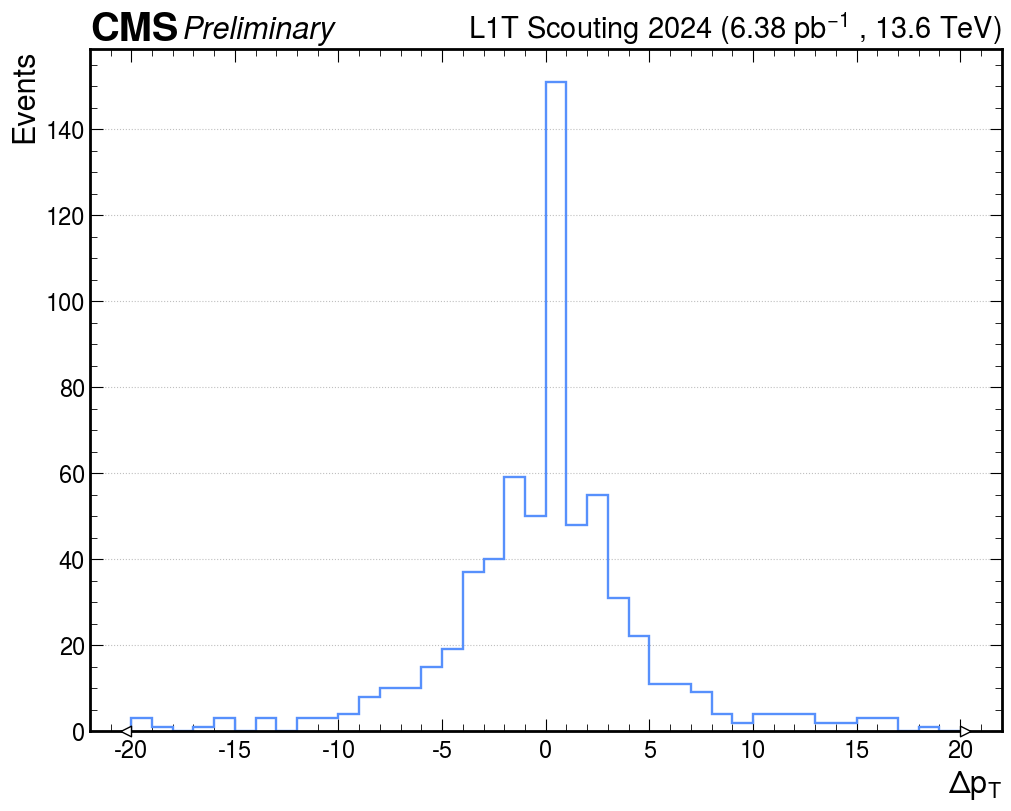

In [58]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(DeltaPt_Hist, lw = 1.7, yerr = 0)

ax.set_xlabel(r'$\Delta p_T$')
ax.set_ylabel(r'Events')
ax.set_axisbelow(True)

ax.legend()

ax.grid(visible=True, axis='y')


ax.tick_params(axis='both', which='minor', length=5, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=9, labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/DeltaPt.pdf")




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


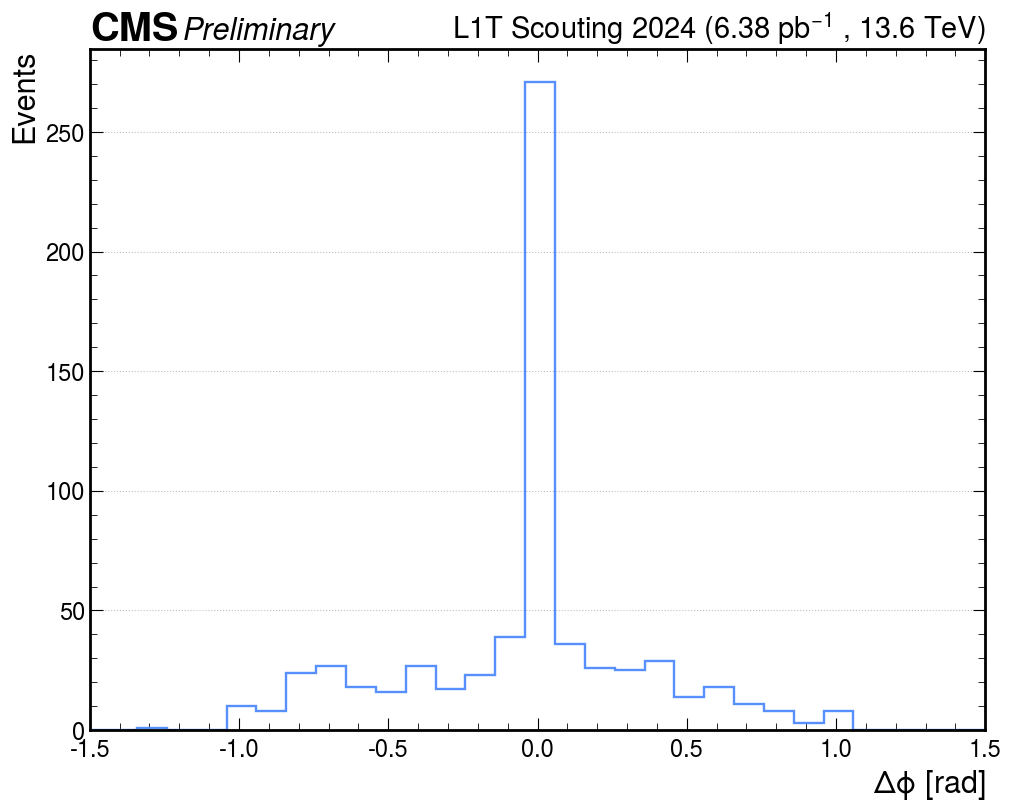

In [59]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(DeltaPhi_Hist, lw = 1.7, yerr = 0)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'Events')
ax.set_axisbelow(True)
ax.set_xlim(-1.5, 1.5)


ax.legend()

ax.grid(visible=True, axis='y')


ax.tick_params(axis='both', which='minor', length=5, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=9, labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/DeltaPhi.pdf")




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


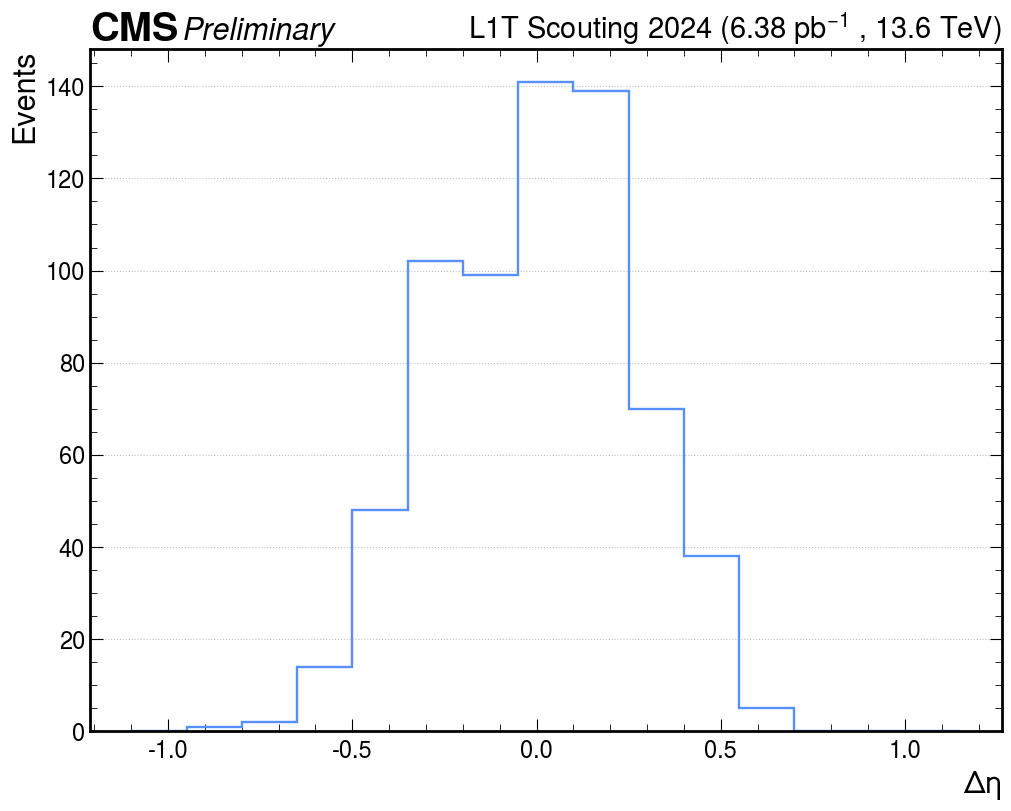

: 

In [ ]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(DeltaEta_Hist, lw = 1.7, yerr = 0)

ax.set_xlabel(r'$\Delta \eta$')
ax.set_ylabel(r'Events')
ax.set_axisbelow(True)

ax.legend()

ax.grid(visible=True, axis='y')


ax.tick_params(axis='both', which='minor', length=5, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=9, labelsize = FONTSIZE - 5)

plt.savefig("../Immagini/DeltaEta.pdf")



In [37]:
def BMTFMuonsFromStubs(Stubs, Features):

   #Feature: 0 == nBmtf, 1 == Pt, 2 == Phi, 3 == Eta, 4 == Sign, 5 == SignValid


   Array3 = []
   Array3More = []
   keys = ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']


   for i in tqdm.tqdm(range(len(Stubs))):

      Dic = {}
      DicP1 = {}

      for feature in ['Pt', 'Phi', 'Eta', 'Qual', 'Sign', 'SignValid']:
         Dic[feature] = []
         DicP1[feature] = []


      if Features[0][Stubs[i]['i']] > 0 or Features[0][Stubs[i]['i'] + 1] > 0:

         if int(np.sum(Stubs[i]['Matched_nStubs'])) <= 3:

            for idx, key in enumerate(keys, start = 1):
               Dic[key].append(Features[idx][Stubs[i]['i']])
               DicP1[key].append(Features[idx][Stubs[i]['i']+1])

            Dictionary = {
               'i': Stubs[i]['i'],
               'bx': Stubs[i]['bx'][0],
               'nBmtf': [Features[0][Stubs[i]['i']], Features[0][Stubs[i]['i'] + 1]],
               'property': Dic,
               'propertyP1': DicP1,
               'Stubs': Stubs[i]
            }

            Array3.append(Dictionary)

         elif np.sum(Stubs[i]['Matched_nStubs']) > 3:

            for idx, key in enumerate(keys, start = 1):
               Dic[key].append(Features[idx][Stubs[i]['i']])
               DicP1[key].append(Features[idx][Stubs[i]['i']+1])

            Dictionary = {
               'i': Stubs[i]['i'],
               'bx': Stubs[i]['bx'][0],
               'nBmtf': [Features[0][Stubs[i]['i']], Features[0][Stubs[i]['i'] + 1]],
               'property': Dic,
               'propertyP1': DicP1,
               'Stubs': Stubs[i]
            }

            Array3More.append(Dictionary)


   return ak.Array(Array3), ak.Array(Array3More)
      

In [38]:
BMTF3Stubs, BMTF3MoreStubs = BMTFMuonsFromStubs(AdjMuons, FeaturesBMTF)

100%|██████████| 721816/721816 [02:15<00:00, 5320.57it/s]


In [ ]:
BMTF3Stubs[50]

In [39]:
pT3StubsP0 = ak.ravel(BMTF3Stubs['property']['Pt'])
pT3StubsP1 = ak.ravel(BMTF3Stubs['propertyP1']['Pt'])
pT3MoreStubsP0 = ak.ravel(BMTF3MoreStubs['property']['Pt'])
pT3MoreStubsP1 = ak.ravel(BMTF3MoreStubs['propertyP1']['Pt'])

pT3Stubs = ak.concatenate([pT3StubsP0, pT3StubsP1])
pT3MoreStubs = ak.concatenate([pT3MoreStubsP0, pT3MoreStubsP1])

Phi3StubsP0 = ak.ravel(BMTF3Stubs['property']['Phi'])
Phi3StubsP1 = ak.ravel(BMTF3Stubs['propertyP1']['Phi'])
Phi3MoreStubsP0 = ak.ravel(BMTF3MoreStubs['property']['Phi'])
Phi3MoreStubsP1 = ak.ravel(BMTF3MoreStubs['propertyP1']['Phi'])

Phi3Stubs = ak.concatenate([Phi3StubsP0, Phi3StubsP1])
Phi3MoreStubs = ak.concatenate([Phi3MoreStubsP0, Phi3MoreStubsP1])

Eta3StubsP0 = ak.ravel(BMTF3Stubs['property']['Eta'])
Eta3StubsP1 = ak.ravel(BMTF3Stubs['propertyP1']['Eta'])
Eta3MoreStubsP0 = ak.ravel(BMTF3MoreStubs['property']['Eta'])
Eta3MoreStubsP1 = ak.ravel(BMTF3MoreStubs['propertyP1']['Eta'])

Eta3Stubs = ak.concatenate([Eta3StubsP0, Eta3StubsP1])
Eta3MoreStubs = ak.concatenate([Eta3MoreStubsP0, Eta3MoreStubsP1])

Qual3StubsP0 = ak.ravel(BMTF3Stubs['property']['Qual'])
Qual3StubsP1 = ak.ravel(BMTF3Stubs['propertyP1']['Qual'])
Qual3MoreStubsP0 = ak.ravel(BMTF3MoreStubs['property']['Qual'])
Qual3MoreStubsP1 = ak.ravel(BMTF3MoreStubs['propertyP1']['Qual'])

Qual3Stubs = ak.concatenate([Qual3StubsP0, Qual3StubsP1])
Qual3MoreStubs = ak.concatenate([Qual3MoreStubsP0, Qual3MoreStubsP1])



# $p_T$ distribution

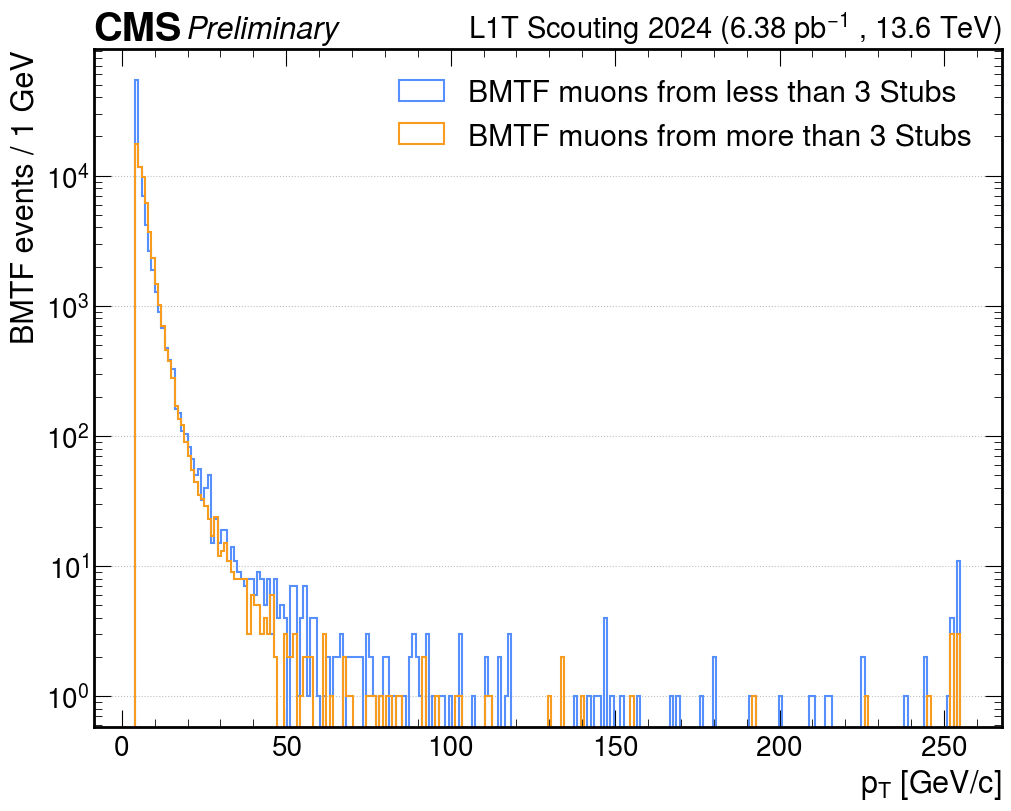

In [55]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)

ax.hist(pT3Stubs, bins = 250,  label='BMTF muons from less than 3 Stubs', histtype='step', linewidth = 1.5, )
ax.hist(pT3MoreStubs, bins = 250,  label='BMTF muons from more than 3 Stubs', histtype='step', linewidth = 1.5, )

ax.set_xlabel(r'$p_T$ [GeV/c]')
ax.set_ylabel(r'BMTF events / 1 GeV')
ax.set_axisbelow(True)

ax.legend()

ax.grid(visible=True, axis='y')
ax.set_yscale('log')

plt.savefig("../Immagini/Pt3And3More.pdf")


## Quality Distribution

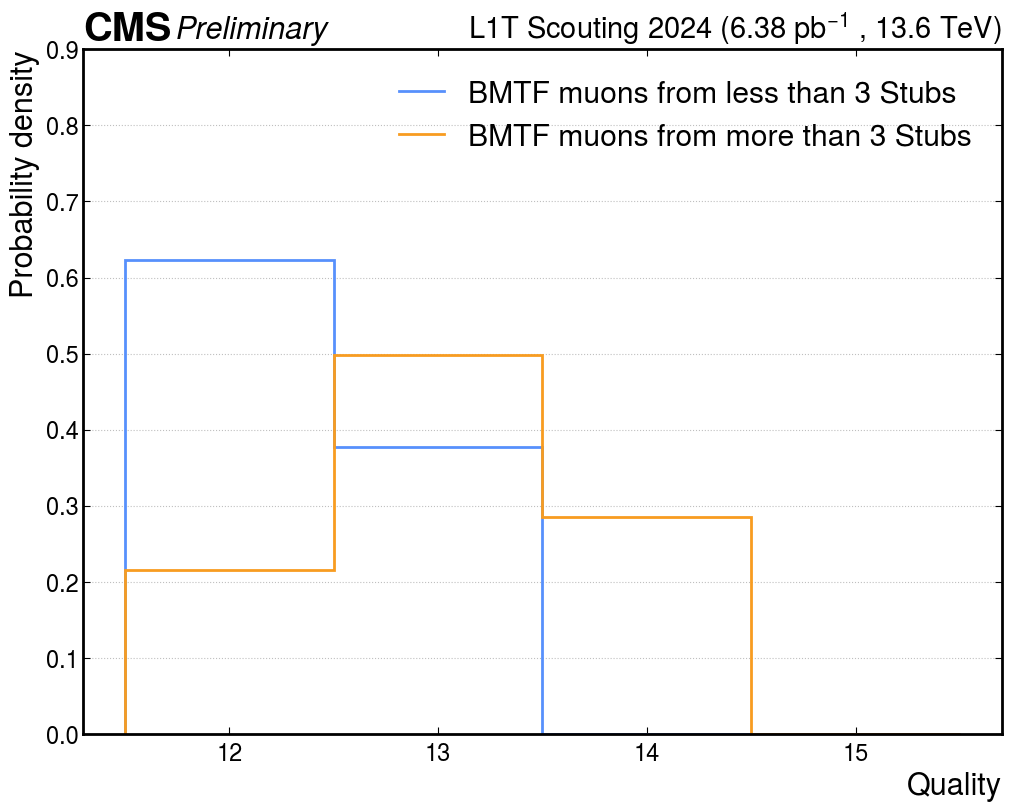

In [60]:
binsQual = np.array(np.arange(12, 17, 1))

QualHist = hist.Hist(hist.axis.Variable(binsQual))
QualHist3More = hist.Hist(hist.axis.Variable(binsQual))

QualHist.fill(Qual3Stubs)
QualHist3More.fill(Qual3MoreStubs)

fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


hep.histplot(QualHist, label="BMTF muons from less than 3 Stubs", density = True, lw = 2, yerr = False)
hep.histplot(QualHist3More, label="BMTF muons from more than 3 Stubs", density = True, lw = 2, yerr = False)
#ax.hist(ak.ravel(BMTFMuonsProperty['property']['Qual']), bins = 4,  label='Unconstrained $p_T$', histtype='step', linewidth = 1.5)

ax.set_xlabel(r'Quality')
ax.set_ylabel(r'Probability density')
ax.set_axisbelow(True)

ax.set_ylim(0, 0.9)
ax.legend()

ax.grid(visible=True, axis='y')
#ax.set_yscale('log')

ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

ax.set_xticks(ticks=np.arange(12.5, 16.5), labels=np.arange(12, 16, 1))

plt.savefig("../Immagini/Qual3And3More.pdf")


In [42]:
binsPhi = np.array(np.arange(-np.pi, np.pi + 0.1, 0.52))
binsEta = np.array(np.arange(-1, 1.1, 0.2))

BMTF3StubsPhi_Hist = hist.Hist(hist.axis.Variable(binsPhi))
BMTF3MoreStubsPhi_Hist = hist.Hist(hist.axis.Variable(binsPhi))

BMTF3StubsEta_Hist = hist.Hist(hist.axis.Variable(binsEta))
BMTF3MoreStubsEta_Hist = hist.Hist(hist.axis.Variable(binsEta))

BMTF3StubsPhi_Hist.fill(Phi3Stubs)
BMTF3MoreStubsPhi_Hist.fill(Phi3MoreStubs)

BMTF3StubsEta_Hist.fill(Eta3Stubs)
BMTF3MoreStubsEta_Hist.fill(Eta3MoreStubs)

print(5)

5


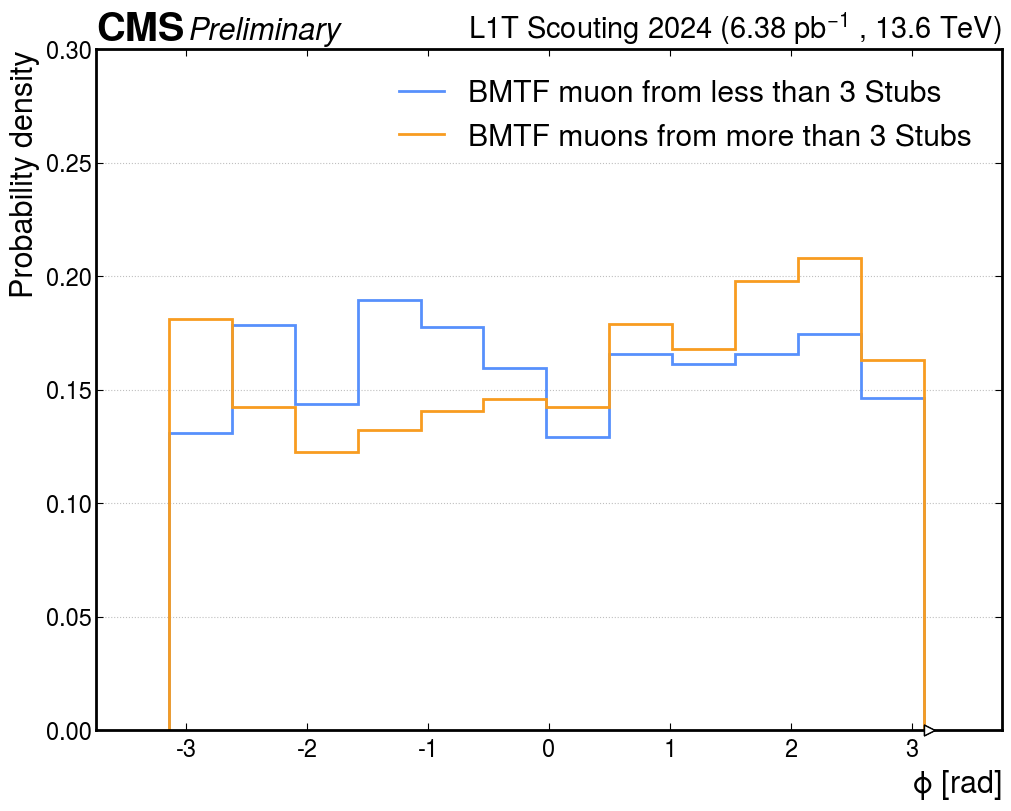

In [ ]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


hep.histplot(BMTF3StubsPhi_Hist, label="BMTF muon from less than 3 Stubs", lw = 2, yerr = False, density=True)
hep.histplot(BMTF3MoreStubsPhi_Hist, label="BMTF muons from more than 3 Stubs", lw = 2, yerr = False, density=True)


ax.set_xlabel(r'$\phi$ [rad]')
ax.set_ylabel(r'Probability density')
ax.set_axisbelow(True)
ax.set_ylim(0, 0.3)
ax.set_xlim(-np.pi - 0.6, np.pi + 0.6)

ax.legend()

ax.grid(visible=True, axis='y')
#ax.set_yscale('log')

ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

#plt.savefig("../Immagini/Phi3And3More.pdf")


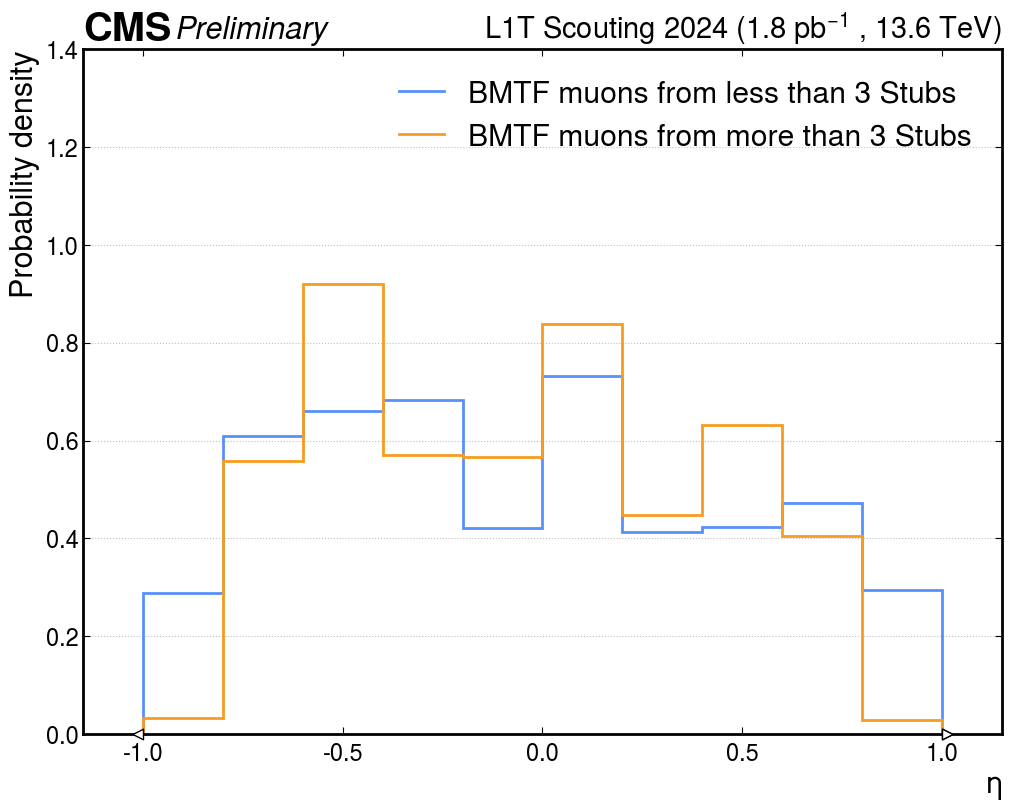

In [ ]:
fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(BMTF3StubsEta_Hist, label="BMTF muons from less than 3 Stubs", lw = 2, density=True, yerr = False)
hep.histplot(BMTF3MoreStubsEta_Hist, label="BMTF muons from more than 3 Stubs", lw = 2, density=True, yerr = False)


ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'Probability density')
ax.set_axisbelow(True)
ax.set_ylim(0, 1.4)
ax.set_xlim(-1.15, 1.15)

ax.legend()

ax.grid(visible=True, axis='y')
#ax.set_yscale('log')

ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

#plt.savefig("../Immagini/Eta3And3More.pdf")


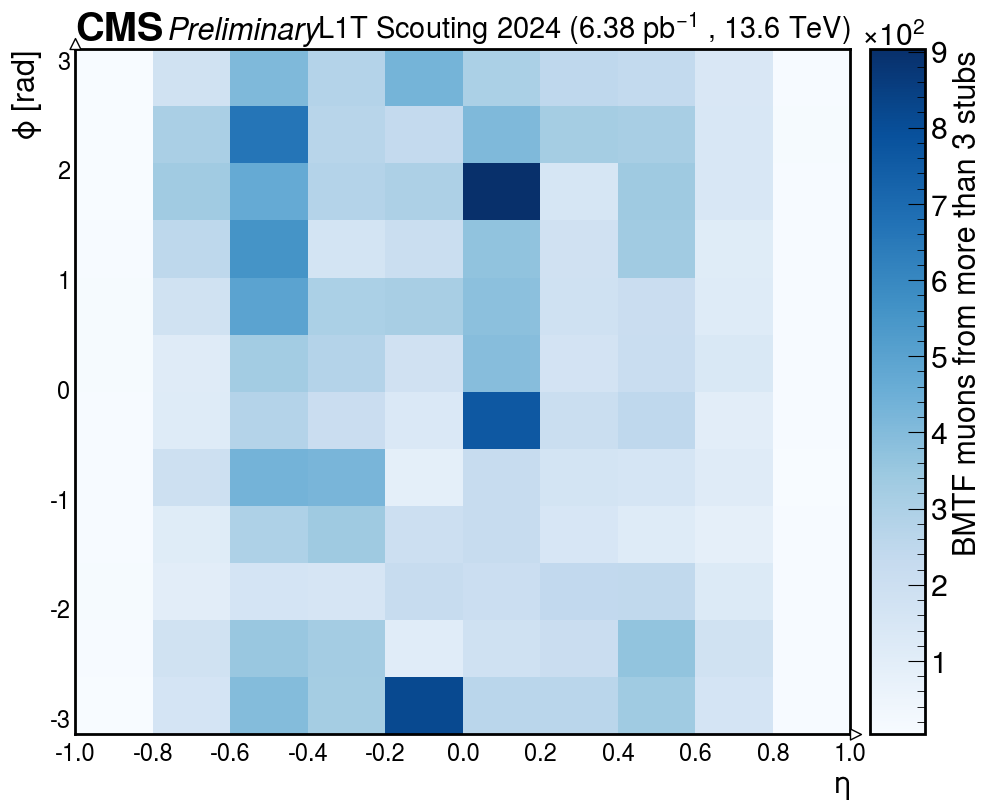

In [45]:
from matplotlib import ticker

hist2d = hist.Hist(
    hist.axis.Variable(binsEta, name='Eta', ),
    hist.axis.Variable(binsPhi, name='Phi'),
)

hist2d3More = hist.Hist(
    hist.axis.Variable(binsEta, name='Eta', ),
    hist.axis.Variable(binsPhi, name='Phi'),
)

hist2d.fill(Phi=ak.ravel(BMTF3Stubs['property']['Phi']), Eta=ak.ravel(BMTF3Stubs['property']['Eta']))
hist2d3More.fill(Phi=ak.ravel(BMTF3MoreStubs['property']['Phi']), Eta=ak.ravel(BMTF3MoreStubs['property']['Eta']))


fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


#hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax)
hep.hist2dplot(hist2d3More, cbar=True, cmap='Blues', ax = ax)

cbar = ax.collections[0].colorbar
cbar.set_label('BMTF muons from more than 3 stubs', fontsize=FONTSIZE)

#Notazione scientifica
cbar.formatter = ticker.ScalarFormatter(useMathText=True)
cbar.formatter.set_scientific(True)  
cbar.formatter.set_powerlimits((-2, 2))  
cbar.update_ticks() 

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\phi$ [rad]')

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

#plt.savefig("../Immagini/2DPhiEtaMore3.pdf")


plt.show()

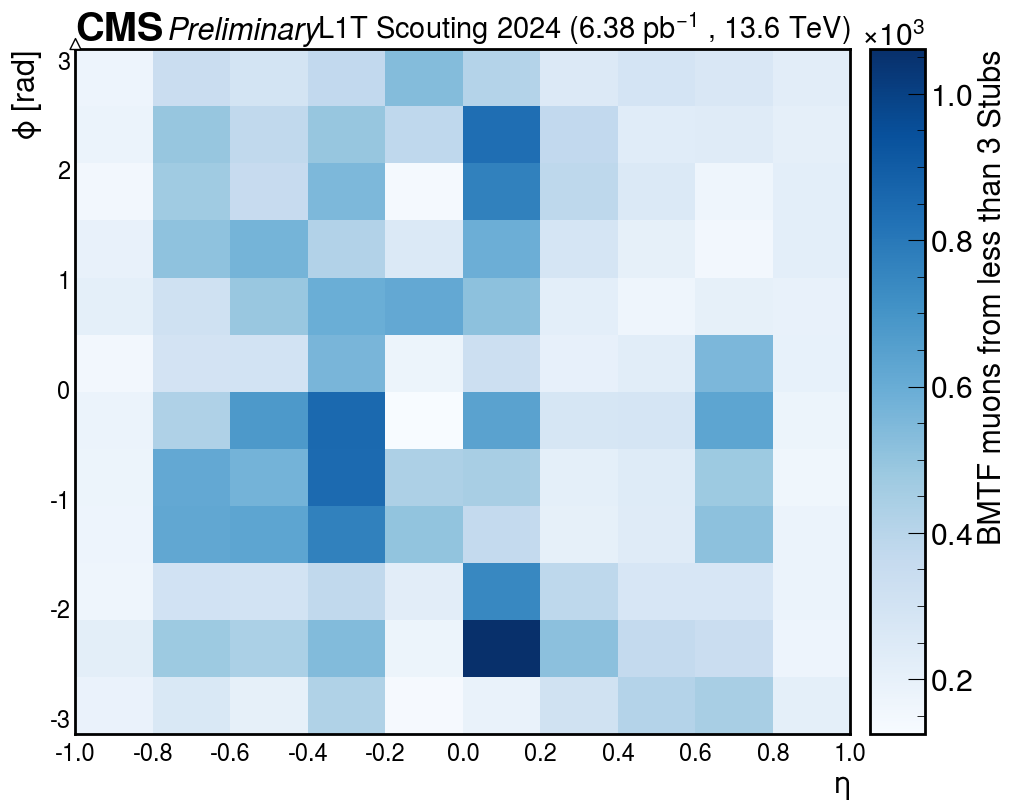

In [46]:
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
MOREdraw_cms_label(ax, fontsize= FONTSIZE)


hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax)
#hep.hist2dplot(hist2d3More, cbar=True, cmap='Blues', ax = ax)

cbar = ax.collections[0].colorbar
cbar.set_label('BMTF muons from less than 3 Stubs', fontsize=FONTSIZE)

#Notazione scientifica
cbar.formatter = ticker.ScalarFormatter(useMathText=True)
cbar.formatter.set_scientific(True)  
cbar.formatter.set_powerlimits((-2, 2))  
cbar.update_ticks() 

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\phi$ [rad]')

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

#plt.savefig("../Immagini/2DPhiEtaLess3.pdf")


plt.show()

In [47]:
nGmt = bmtf_gmt.nGmtMuons
GmtPt = bmtf_gmt.gmtPt
GmtPhi = bmtf_gmt.gmtPhiAtVtx
GmtEta = bmtf_gmt.gmtEtaAtVtx
GmtQual = bmtf_gmt.gmtQual


FeaturesGMT = [nGmt, GmtPt, GmtPhi, GmtEta, GmtQual]

In [48]:
def MatchGMT(BMTF, Features):


   Array = []

   for i in tqdm.tqdm(range(len(BMTF))):

      Dic = {}
      DicP1 = {}

      for feature in ['GmtPt', 'GmtPhi', 'GmtEta', 'GmtQual']:
         Dic[feature] = []
         DicP1[feature] = []

      if Features[0][BMTF[i]['i']] > 0 and Features[0][BMTF[i]['i'] + 1] > 0:
         keys = ['GmtPt', 'GmtPhi', 'GmtEta', 'GmtQual']
         for idx, key in enumerate(keys, start = 1):
            Dic[key].append(Features[idx][BMTF[i]['i']])
            DicP1[key].append(Features[idx][BMTF[i]['i'] + 1])

      
         Dictionary = {
            'i': BMTF[i]['i'],
            'bx': BMTF[i]['bx'],
            'nGmt': [Features[0][BMTF[i]['i']], Features[0][BMTF[i]['i'] + 1]],
            'property': Dic,
            'propertyP1': DicP1,
            'BMTF': BMTF[i],
         }


         Array.append(Dictionary)

   return ak.Array(Array)

In [49]:
MatchedGMT = MatchGMT(MatchBMTF, FeaturesGMT)

100%|██████████| 659/659 [00:00<00:00, 1645.49it/s]


In [50]:
def CheckNearCompatibleStubs(Muons):

   Diff = []

   for i in tqdm.tqdm(range(len(Muons))):
      diff = (Muons[i]['bx'][1] - Muons[i]['bx'][0])

      Diff.append(diff)

   Diff = np.array(Diff)

   return Diff[Diff > 0]

In [51]:
DiffCount = CheckNearCompatibleStubs(AdjMuons)


100%|██████████| 721816/721816 [00:48<00:00, 14988.50it/s]


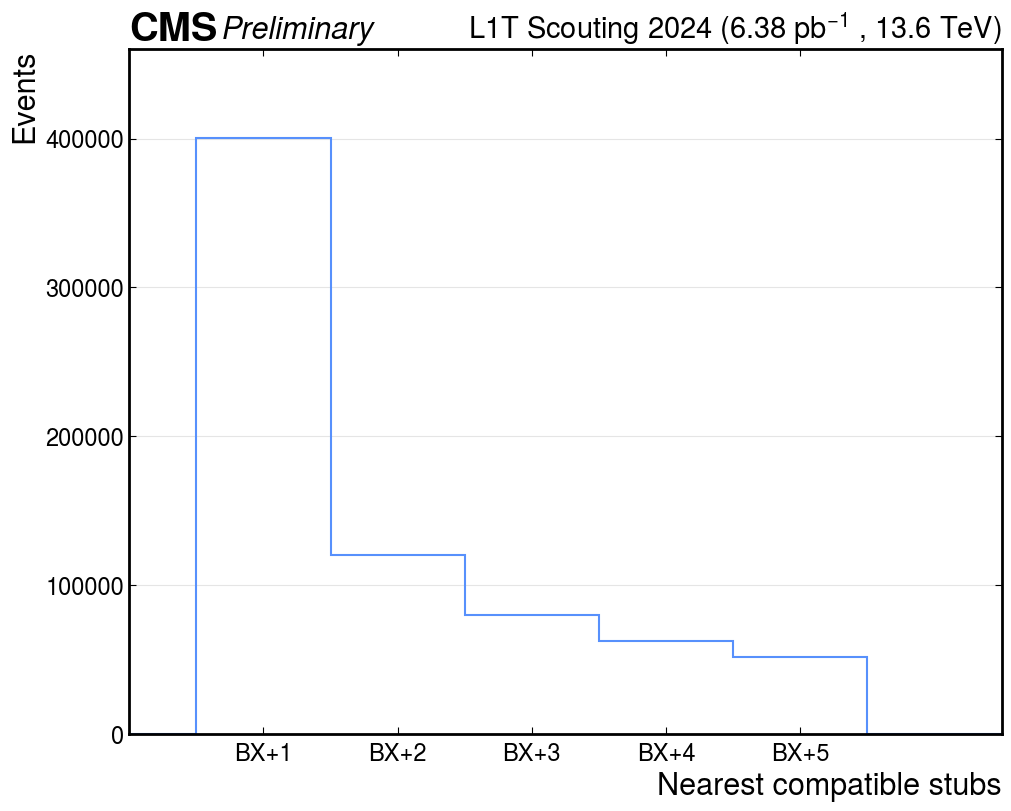

In [71]:
DiffCount_Hist = hist.Hist(hist.axis.Variable(np.arange(200)))
DiffCountMuons_Hist = hist.Hist(hist.axis.Variable(np.arange(200)))


#DiffCount_Hist.fill(DiffCount)
DiffCountMuons_Hist.fill(DiffCount)

fig, ax = plt.subplots(figsize= FIGSIZE, constrained_layout=True)

set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE - 2)
draw_grid(ax, axis="y")

MOREdraw_cms_label(ax, fontsize= FONTSIZE)

#hep.histplot(DiffCount_Hist, yerr = 0)
hep.histplot(DiffCountMuons_Hist, yerr = 0)

ax.set_xlim(0.5, 7)
ax.set_ylim(0, 460_000)

ax.tick_params(axis='both', which='minor', length=0, labelsize = FONTSIZE - 5)
ax.tick_params(axis='both', which='major', length=5, labelsize = FONTSIZE - 5)

ax.set_xticks(np.arange(1, 6)+0.5)
#ax.set_xticklabels(np.arange(1, 6))
ax.set_xticklabels(["BX+1", "BX+2", "BX+3", "BX+4", "BX+5"])

ax.set_ylabel("Events")
ax.set_xlabel("Nearest compatible stubs")

#ax.set_yscale('log')

plt.savefig("../Immagini/NearCompatibleStubs.pdf")